# Tugas 3 Deep Learning - Classification - Transformer Version

### Kelompok 3
- Muhammad Alvinza (2304879)
- Muhammad Ichsan Khairullah (2306924)
- Abdurrahman Rauf Budiman (2301102)
- Rasendriya Andhika (2305309)

## Pendahuluan

Pada Tugas 3 ini, kelompok kami diberikan tantangan untuk mengeksplorasi dan membandingkan performa tiga arsitektur neural network yang berbeda dalam menyelesaikan tugas klasifikasi sentimen: Recurrent Neural Network (RNN), Long Short-Term Memory (LSTM), dan Transformer. Ketiga model ini dirancang dengan framework TensorFlow/Keras untuk memproses sequence data berupa teks review dan mengklasifikasikan sentimen menjadi positif atau negatif. Tugas ini merupakan kelanjutan dari Tugas 2 yang sebelumnya fokus pada implementasi LSTM, dan kini diperluas untuk mengeksplorasi arsitektur Transformer yang merupakan state-of-the-art dalam bidang Natural Language Processing (NLP), serta membandingkannya dengan pendekatan recurrent tradisional (RNN dan LSTM).

Transformer, yang diperkenalkan dalam paper "Attention is All You Need" (Vaswani et al., 2017), merupakan arsitektur revolusioner yang mengandalkan mekanisme self-attention untuk menangkap relasi antar kata dalam sequence tanpa ketergantungan pada struktur recurrent. Berbeda dengan RNN yang memproses data secara sequential dan LSTM yang menambahkan memory cell untuk mengatasi vanishing gradient problem, Transformer memproses seluruh sequence secara paralel menggunakan multi-head attention mechanism dan positional encoding. Dalam implementasi kami, model Transformer dibangun dengan komponen custom layers: PositionalEmbedding untuk menyematkan informasi posisi kata dalam sequence, dan TransformerEncoder yang menggabungkan multi-head attention dengan feed-forward networks. Model ini kemudian dibandingkan dengan baseline RNN (Simple RNN) dan LSTM standar untuk menganalisis trade-off antara kompleksitas arsitektur dengan performa klasifikasi.

Dataset yang digunakan identik dengan Tugas 2, yaitu kumpulan review dengan rating 1-5 yang telah melalui preprocessing komprehensif meliputi text cleaning (lowercase conversion, emoticon handling, URL removal, mention removal), filtering review pendek (minimal 5 kata), dan label binarization (rating 1-3 menjadi negatif/0, rating 4-5 menjadi positif/1). Dataset kemudian dibagi menjadi training (70%), validation (15%), dan testing (15%) sets. Proses tokenisasi menggunakan vocabulary size 10,000 kata dengan maximum sequence length 40 tokens, dilengkapi padding untuk normalisasi panjang input. Analisis eksploratori data menunjukkan distribusi sentimen yang relatif balanced (53.7% negatif vs 46.3% positif) dengan karakteristik text yang beragam panjangnya.

Proses pelatihan ketiga model dilakukan dengan konfigurasi yang comparable: semua menggunakan embedding dimension 128, Adam optimizer dengan learning rate 0.001, binary crossentropy loss function, dan early stopping callback dengan patience 3 untuk mencegah overfitting. RNN diimplementasikan sebagai baseline sederhana dengan single SimpleRNN layer (64 units) dilengkapi dropout 0.5. LSTM menggunakan arsitektur serupa dengan LSTM layer (64 units) dan dropout regulasi. Transformer mengimplementasikan arsitektur yang lebih complex: embedding layer diikuti positional encoding, transformer encoder block dengan multi-head attention (4 heads, key dimension 128, feed-forward dimension 128), global average pooling, dan dense layers untuk klasifikasi. Setelah training, dilakukan evaluasi komprehensif menggunakan multiple metrics (accuracy, precision, recall, F1-score, ROC AUC) serta visualisasi mendalam melalui ROC curves, Precision-Recall curves, confusion matrices, dan radar charts untuk comparative analysis.

Selain evaluasi performa klasifikasi, tugas ini juga melakukan analisis komparatif menyeluruh meliputi: (1) Model complexity comparison berdasarkan jumlah parameter dan inference time, (2) Prediction confidence distribution analysis untuk memahami decision boundary characteristics, (3) Error pattern analysis melalui confusion matrix untuk mengidentifikasi systematic biases, dan (4) Multi-dimensional performance visualization menggunakan radar chart untuk holistic comparison. Hasil analisis menunjukkan bahwa meskipun Transformer memiliki reputasi sebagai state-of-the-art architecture, performa actual sangat bergantung pada karakteristik dataset dan task complexity. Dalam kasus sentiment analysis dengan sequence length pendek (MAX_LEN=40) dan vocabulary terbatas (10K words), advantage dari self-attention mechanism tidak selalu termanifestasi dalam improvement signifikan dibanding LSTM yang lebih sederhana.

Dengan demikian, tujuan utama dari Tugas 3 ini adalah: (1) Memahami dan mengimplementasikan arsitektur Transformer dengan custom layers (PositionalEmbedding dan TransformerEncoder) menggunakan TensorFlow/Keras, (2) Membandingkan performa Transformer dengan baseline models (RNN dan LSTM) secara objektif menggunakan multiple evaluation metrics, (3) Menganalisis trade-off antara model complexity (parameter count, inference time) dengan prediction performance (accuracy, AUC, F1-score), (4) Memahami karakteristik dan limitation dari masing-masing arsitektur dalam konteks sentiment analysis task, dan (5) Mengembangkan kemampuan critical thinking dalam memilih arsitektur model yang optimal berdasarkan business requirements, computational constraints, dan dataset characteristics. Melalui comprehensive analysis dan visualization, kami berharap dapat memberikan insights yang valuable untuk decision-making dalam real-world deployment scenarios di bidang Natural Language Processing dan sentiment analysis.

In [4]:
# Import required libraries
from pathlib import Path
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, SimpleRNN, Bidirectional, Dense, Dropout, MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D, Layer, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully!
Pandas version: 2.2.2
NumPy version: 1.26.4


## Load Dataset

**Tujuan**: Memuat dataset review yang akan digunakan untuk training model sentiment analysis.

**Step yang dilakukan**:
1. Membaca file CSV menggunakan `pd.read_csv()` dari folder Dataset
2. Menampilkan 5 baris pertama dengan `df.head()` untuk melihat struktur data

**Mengapa langkah ini penting**:
- Dataset berisi review teks dan rating numerik (1-5) yang akan menjadi dasar pembelajaran model
- Kita perlu memahami struktur dan format data sebelum melakukan preprocessing
- Mengetahui kolom-kolom yang tersedia dan tipe datanya untuk langkah selanjutnya

In [5]:
df = pd.read_csv("reviews.csv")
df.head()


,date,review,rating,thumbs_up,version
0,2021-09-30 06:12:53,"Udah di coba, keren dan responsive, dengan tam...",5,36,1.0.0
1,2021-09-30 06:33:15,Excellent,5,0,1.0.0
2,2021-09-30 06:48:30,Keren. Cakep benar semakin canggih. Terdepan t...,5,22,1.0.0
3,2021-09-30 06:56:05,mantap,5,0,NaN
4,2021-09-30 07:02:21,Mantap,5,0,1.0.0


## Exploratory Data Analysis (EDA)

**Tujuan**: Memahami karakteristik, distribusi, dan kualitas dataset sebelum melakukan preprocessing.

**Analisis yang akan dilakukan**:
1. **Dataset Overview**: Bentuk data, kolom, dan tipe data
2. **Missing Values**: Identifikasi data yang hilang
3. **Rating Distribution**: Distribusi rating 1-5
4. **Text Statistics**: Panjang review, kata-kata yang sering muncul
5. **Data Quality**: Duplikasi dan outliers
6. **Sample Analysis**: Contoh review untuk setiap rating

**Mengapa EDA penting**:
- **Understanding data**: Mengenal karakteristik dataset sebelum modeling
- **Data quality**: Mengidentifikasi masalah yang perlu diperbaiki
- **Feature engineering**: Insights untuk preprocessing dan feature selection
- **Model strategy**: Menentukan approach yang tepat berdasarkan distribusi data

In [6]:
# Membersihkan data - hanya ambil kolom Sentiment dan Text Tweet
# Text Tweet sebagai X (fitur), Sentiment sebagai Y (target)
df_clean = df[['review', 'rating']].copy()

# Cek data yang hilang
print("Data yang hilang:")
print(df_clean.isnull().sum())
print(f"\nJumlah data sebelum pembersihan: {len(df)}")

# Hapus data yang memiliki nilai kosong
df_clean = df_clean.dropna()
print(f"Jumlah data setelah pembersihan: {len(df_clean)}")
df_clean.head()

Data yang hilang:
review    0
rating    0
dtype: int64

Jumlah data sebelum pembersihan: 155192
Jumlah data setelah pembersihan: 155192


,review,rating
0,"Udah di coba, keren dan responsive, dengan tam...",5
1,Excellent,5
2,Keren. Cakep benar semakin canggih. Terdepan t...,5
3,mantap,5
4,Mantap,5


In [7]:
print(df_clean['rating'].value_counts().sort_index())

rating
1    39183
2     9379
3     9464
4    10951
5    86215
Name: count, dtype: int64


## Convert Rating ke Sentiment Binary

**Tujuan**: Mengubah masalah multiclass (rating 1-5) menjadi binary classification (positif/negatif).

**Step yang dilakukan**:
1. **Definisi fungsi**: Membuat `rating_to_sentiment()` yang memetakan:
   - Rating 1-3 → Sentiment Negatif (0) 
   - Rating 4-5 → Sentiment Positif (1)
2. **Apply mapping**: Menggunakan `df_clean['rating'].apply()` untuk menerapkan fungsi ke semua data
3. **Verifikasi hasil**: Menampilkan distribusi mapping dan contoh data

**Mengapa langkah ini penting**:
- **Simplifikasi problem**: Binary classification lebih mudah dipelajari model daripada multiclass
- **Interpretabilitas**: Hasil lebih mudah diinterpretasi (positif vs negatif) dibanding 5 kelas rating
- **Balance dataset**: Mengurangi kemungkinan class imbalance yang ekstrem
- **Fokus sentiment**: Kita lebih tertarik pada polaritas emosi daripada tingkat rating spesifik
- **Performa model**: Binary classification umumnya memiliki akurasi yang lebih tinggi

In [8]:
def rating_to_sentiment(rating):
    """
    Convert rating (1-5) to binary sentiment
    1-3: Negative (0)
    4-5: Positive (1)
    """
    if rating <= 3:
        return 0  # Negative
    else:
        return 1  # Positive

In [9]:
# Apply mapping
df_clean['Sentiment'] = df_clean['rating'].apply(rating_to_sentiment)

# Verifikasi hasil mapping
print("\nMapping Results:")
print(df_clean[['rating', 'Sentiment']].value_counts().sort_index())

print("\nNew Sentiment Distribution:")
sentiment_counts = df_clean['Sentiment'].value_counts()
print(f"Negative (0): {sentiment_counts.get(0, 0)} ({sentiment_counts.get(0, 0)/len(df_clean)*100:.1f}%)")
print(f"Positive (1): {sentiment_counts.get(1, 0)} ({sentiment_counts.get(1, 0)/len(df_clean)*100:.1f}%)")

# Show sample
print("\n📝 Sample Data:")
print(df_clean[['review', 'rating', 'Sentiment']].head(10))


Mapping Results:
rating  Sentiment
1       0            39183
2       0             9379
3       0             9464
4       1            10951
5       1            86215
Name: count, dtype: int64

New Sentiment Distribution:
Negative (0): 58026 (37.4%)
Positive (1): 97166 (62.6%)

📝 Sample Data:
                                              review  rating  Sentiment
0  Udah di coba, keren dan responsive, dengan tam...       5          1
1                                          Excellent       5          1
2  Keren. Cakep benar semakin canggih. Terdepan t...       5          1
3                                             mantap       5          1
4                                             Mantap       5          1
5  mantap jiwa dan raga... ayo kita livinkan indo...       5          1
6                              Mandiri emang terbaik       5          1
7                                        Super App 👍       5          1
8                                          Nice apps  

## Text Cleaning

**Tujuan**: Membersihkan dan menormalisasi teks agar model dapat memproses dengan optimal.

**Step yang dilakukan**:
1. **Lowercase conversion**: Mengubah semua huruf menjadi kecil menggunakan `str.lower()`
2. **Emoticon handling**: Mengkonversi emoticon (`:)`, `:(`, dll.) menjadi kata sentiment ("happy", "sad")
3. **Remove noise**: Menghapus URL, mentions (@username), hashtags (#tag), dan angka
4. **Character normalization**: Mengurangi karakter berulang (contoh: "goooood" → "good")
5. **Text cleaning**: Hanya menyimpan huruf dan spasi, menghapus karakter khusus
6. **Length filtering**: Menghapus review dengan kurang dari 3 kata
7. **Statistical analysis**: Menampilkan statistik vocabulary, panjang kalimat, dan distribusi data

**Mengapa setiap step penting**:
- **Lowercase**: Menghindari duplikasi kata ("Good" vs "good" dianggap sama)
- **Emoticon handling**: Emoticon mengandung informasi sentiment yang berharga
- **Remove noise**: URL dan mention tidak relevan untuk sentiment, bisa mengganggu pembelajaran
- **Character normalization**: Mengurangi variasi kata yang tidak perlu
- **Text cleaning**: Standardisasi format teks untuk konsistensi input
- **Length filtering**: Review terlalu pendek tidak memiliki konteks yang cukup untuk analisis sentiment
- **Statistical analysis**: Membantu menentukan parameter optimal untuk model (MAX_LEN, MAX_WORDS)

**Output yang dihasilkan**:
- Teks yang bersih dan konsisten
- Statistik vocabulary size dan distribusi panjang kalimat
- Rekomendasi parameter untuk tokenisasi

In [10]:
print("Starting data cleaning process...")
print(f"Data sebelum cleaning: {len(df_clean)} reviews")

# 1. Convert to lowercase
df_clean['review_clean'] = df_clean['review'].str.lower()

# 2. Remove special characters, numbers, and extra whitespaces using regex
import re

def clean_text(text):
    if pd.isna(text):
        return ""
    
    # Dictionary untuk emoticon handling - convert to sentiment words
    emoticon_dict = {
        # Happy variations
        ':)': 'positive', ':-)': 'positive', '=)': 'positive', ':]': 'positive',
        ':D': 'very positive', ':-D': 'very positive', '=D': 'very positive', 'XD': 'very positive',
        '^_^': 'positive', '^-^': 'positive', ':P': 'playful', ':-P': 'playful',
        
        # Sad variations  
        ':(': 'negative', ':-(': 'negative', '=(': 'negative', ':[': 'negative',
        ":'(": 'very negative', ":'-(" : 'very negative', 'T_T': 'very negative', 'T.T': 'very negative',
        
        # Love/Heart
        '<3': 'love', '</3': 'disappointed', '<33': 'love', '<333': 'love',
        
        # Neutral/Other
        ':|': 'neutral', ':-|': 'neutral', '=|': 'neutral',
        ';)': 'positive', ';-)': 'positive', ';P': 'playful',
        ':o': 'surprised', ':O': 'surprised', 'O_O': 'surprised',
        ':*': 'affection', ':-*': 'affection', 'xoxo': 'affection'
    }
    
    # Replace emoticons dengan sentiment words
    for emoticon, sentiment in emoticon_dict.items():
        text = text.replace(emoticon, f' {sentiment} ')
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove mentions (@username) and hashtags (#hashtag)
    text = re.sub(r'@\w+|#\w+', '', text)
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Replace repeated characters (3 or more) with two characters
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    
    # Remove special characters and punctuation (keep only alphabets and spaces)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply text cleaning
df_clean['review_clean'] = df_clean['review_clean'].apply(clean_text)

# 3. Remove reviews that are too short (less than 3 words)
# Count words in each review
df_clean['word_count'] = df_clean['review_clean'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

print(f"\nWord count statistics before filtering:")
print(f"Mean words per review: {df_clean['word_count'].mean():.1f}")
print(f"Median words per review: {df_clean['word_count'].median():.1f}")
print(f"Min words: {df_clean['word_count'].min()}")
print(f"Max words: {df_clean['word_count'].max()}")

# Set minimum word count (keeping reviews with at least 3 words)
MIN_WORDS = 3
df_before_filter = len(df_clean)
df_clean = df_clean[df_clean['word_count'] >= MIN_WORDS].copy()

print(f"\nFiltering reviews with less than {MIN_WORDS} words:")
print(f"Reviews removed: {df_before_filter - len(df_clean)}")
print(f"Remaining reviews: {len(df_clean)}")
print(f"Data retention: {len(df_clean)/df_before_filter*100:.1f}%")

# 4. Remove empty reviews after cleaning
df_clean = df_clean[df_clean['review_clean'].str.strip() != ''].copy()
    

Starting data cleaning process...
Data sebelum cleaning: 155192 reviews

Word count statistics before filtering:
Mean words per review: 8.9
Median words per review: 5.0
Min words: 0
Max words: 100

Filtering reviews with less than 3 words:
Reviews removed: 56289
Remaining reviews: 98903
Data retention: 63.7%

Word count statistics before filtering:
Mean words per review: 8.9
Median words per review: 5.0
Min words: 0
Max words: 100

Filtering reviews with less than 3 words:
Reviews removed: 56289
Remaining reviews: 98903
Data retention: 63.7%


In [11]:
print(f"Final cleaning results:")
print(f"Final data count: {len(df_clean)} reviews")
print(f"Average words per review: {df_clean['word_count'].mean():.1f}")

# Check sentiment distribution after cleaning
print(f"\nSentiment distribution after cleaning:")
sentiment_counts_clean = df_clean['Sentiment'].value_counts()
print(f"Negative (0): {sentiment_counts_clean.get(0, 0)} ({sentiment_counts_clean.get(0, 0)/len(df_clean)*100:.1f}%)")
print(f"Positive (1): {sentiment_counts_clean.get(1, 0)} ({sentiment_counts_clean.get(1, 0)/len(df_clean)*100:.1f}%)")

# Show sample cleaned data
print(f"\nSample cleaned data:")
sample_df = df_clean[['review', 'review_clean', 'word_count', 'rating', 'Sentiment']].head()
for idx, row in sample_df.iterrows():
    print(f"\nOriginal: {row['review'][:100]}...")
    print(f"Cleaned:  {row['review_clean'][:100]}...")
    print(f"Words: {row['word_count']}, Rating: {row['rating']}, Sentiment: {row['Sentiment']}")

# ============================================
# 📈 ANALISIS STATISTIK SETELAH CLEANING
# ============================================

print("\nAnalisis Data Setelah Cleaning:")

# 1. Vocabulary Analysis
all_words = []
for review in df_clean['review_clean']:
    if isinstance(review, str):
        all_words.extend(review.split())

vocab_size = len(set(all_words))
sentence_lengths = df_clean['word_count'].values

# 2. Summary Statistics
print(f"Total kata unik: {vocab_size:,}")
print(f"Panjang rata-rata: {sentence_lengths.mean():.1f} kata")
print(f"Panjang maksimum: {sentence_lengths.max()} kata")

# 3. Recommended LSTM Parameters
recommended_max_len = int(np.percentile(sentence_lengths, 95))
print(f"MAX_LEN yang disarankan: {recommended_max_len}")
print(f"MAX_WORDS yang disarankan: {min(vocab_size, 10000):,}")

# 4. Data Balance Check
sentiment_counts = df_clean['Sentiment'].value_counts()
imbalance_ratio = sentiment_counts.max() / sentiment_counts.min()
print(f"⚖️ Rasio keseimbangan data: {imbalance_ratio:.2f}:1", 
      "✅" if imbalance_ratio <= 1.5 else "⚠️")

# Drop the word_count column as it's no longer needed
df_clean = df_clean.drop('word_count', axis=1)


Final cleaning results:
Final data count: 98903 reviews
Average words per review: 13.2

Sentiment distribution after cleaning:
Negative (0): 53158 (53.7%)
Positive (1): 45745 (46.3%)

Sample cleaned data:

Original: Udah di coba, keren dan responsive, dengan tampilan yang makin segar pastinya!...
Cleaned:  udah di coba keren dan responsive dengan tampilan yang makin segar pastinya...
Words: 12, Rating: 5, Sentiment: 1

Original: Keren. Cakep benar semakin canggih. Terdepan terpercaya tumbuh bersama anda....
Cleaned:  keren cakep benar semakin canggih terdepan terpercaya tumbuh bersama anda...
Words: 10, Rating: 5, Sentiment: 1

Original: mantap jiwa dan raga... ayo kita livinkan indonesia...
Cleaned:  mantap jiwa dan raga ayo kita livinkan indonesia...
Words: 8, Rating: 5, Sentiment: 1

Original: Mandiri emang terbaik...
Cleaned:  mandiri emang terbaik...
Words: 3, Rating: 5, Sentiment: 1

Original: Livin semakin canggih, Mantap Jiwa Me-livin-kan indonesia...
Cleaned:  livin semakin ca

## Analisis Statistik & Rekomendasi Panjang

## Split Data - Pembagian Dataset

**Tujuan**: Membagi dataset menjadi train, validation, dan test set untuk evaluasi model yang proper.

**Step yang dilakukan**:
1. **First split**: 80% training, 20% temporary (menggunakan `train_test_split`)
2. **Second split**: Membagi 20% temporary menjadi 10% validation dan 10% test
3. **Stratification**: Menggunakan parameter `stratify=y` untuk mempertahankan proporsi kelas

**Pembagian final**:
- **Train (80%)**: Untuk melatih model, mempelajari pola dan weight
- **Validation (10%)**: Untuk monitoring training dan tuning hyperparameter  
- **Test (10%)**: Untuk evaluasi final performa model

**Mengapa pembagian ini penting**:
- **Train set**: Model belajar dari data ini, semakin banyak semakin baik (dengan syarat tidak overfitting)
- **Validation set**: Mencegah overfitting dengan monitoring performa pada data yang tidak dilatih
- **Test set**: Memberikan estimasi performa real-world yang tidak bias
- **Stratification**: Memastikan proporsi positif/negatif sama di semua split, mencegah bias
- **Separate test**: Test set benar-benar "unseen" oleh model selama training dan validation

**Best practice**: Test set tidak boleh dilihat sama sekali sampai evaluasi final!

In [12]:
# Membuat variabel X dan Y untuk model LSTM
# X = Text Tweet yang sudah dibersihkan (review_clean)
# Y = Sentiment
X = df_clean['review_clean'].values  # Menggunakan review yang sudah dibersihkan
y = df_clean['Sentiment'].values

print(f"Data untuk training:")
print(f"Jumlah samples: {len(X)}")
print(f"Contoh X (review cleaned): {X[0]}")
print(f"Contoh Y (sentiment): {y[0]}")


Data untuk training:
Jumlah samples: 98903
Contoh X (review cleaned): udah di coba keren dan responsive dengan tampilan yang makin segar pastinya
Contoh Y (sentiment): 1


## Split Data (Train/Val/Test)
Membagi data menjadi train 80%, validation 10%, dan test 10% secara stratified.

In [13]:

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,  # 50% dari 20% = 10% total
    random_state=42,
    stratify=y_temp
)


In [14]:
MAX_WORDS = 10000
MAX_LEN = 40

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)  # Hanya dari TRAIN!

# Tokenize semua split
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LEN, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post')

print(f"Train shape: {X_train_pad.shape}")
print(f"Val shape: {X_val_pad.shape}")
print(f"Test shape: {X_test_pad.shape}")

Train shape: (79122, 40)
Val shape: (9890, 40)
Test shape: (9891, 40)


In [15]:
print(np.unique(y_train))  # Harus output: [0 1]
print(y_train.shape)       # Harus (13304,) bukan (13304, 1)

[0 1]
(79122,)


## RNN

Disini kami menambahkan model RNN yang nantinya akan kami bandingkan terkait performa klasifikasi sentimen. RNN merupakan arsitektur dasar untuk sequential data yang memproses input secara berurutan dengan hidden state sebagai memori. Namun, RNN memiliki kelemahan yaitu vanishing gradient problem yang membuat sulit mempelajari long-term dependencies.

### Build Model

In [16]:
model = Sequential([
    Input(shape=(MAX_LEN,)),
    Embedding(input_dim=MAX_WORDS, output_dim=32),
    SimpleRNN(32, return_sequences=False, dropout=0.2, recurrent_dropout=0.2),  # Kurangi ke 32, tambah dropout
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 40, 32)         │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 323,169 (1.23 MB)

 Trainable params: 323,169 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

### Training Model

In [17]:
# # ============================================
# # TRAIN MODEL
# # ============================================

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)


history = model.fit(
    X_train_pad, y_train,
    epochs=20,
    batch_size=328,
    validation_data=(X_val_pad, y_val),  # ← Pakai VAL, bukan TEST!
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.6734 - loss: 0.6062 - val_accuracy: 0.7429 - val_loss: 0.5593
Epoch 2/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.6734 - loss: 0.6062 - val_accuracy: 0.7429 - val_loss: 0.5593
Epoch 2/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7396 - loss: 0.5698 - val_accuracy: 0.7486 - val_loss: 0.5558
Epoch 3/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7396 - loss: 0.5698 - val_accuracy: 0.7486 - val_loss: 0.5558
Epoch 3/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7484 - loss: 0.5636 - val_accuracy: 0.7563 - val_loss: 0.5551
Epoch 4/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7484 - loss: 0.5636 - val_accuracy: 0.7563 - val_loss: 0.5551
Epoch 4/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.7552 - loss: 0.5596 - val_accuracy: 0.7563 - val_loss: 0.5560
Epoch 5/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.7552 - loss: 0.5596 - val_accu

### Evaluating Model

In [18]:
print("\nEvaluating model...")
test_loss, test_acc = model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

y_pred = (model.predict(X_test_pad) > 0.5).astype(int).flatten()
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['negative', 'positive']))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Evaluating model...
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7719 - loss: 0.5334
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7719 - loss: 0.5334
Test Accuracy: 0.7719
Test Loss: 0.5334
Test Accuracy: 0.7719
Test Loss: 0.5334
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Classification Report:
              precision    recall  f1-score   support

    negative       0.81      0.75      0.78      5316
    positive       0.74      0.79      0.76      4575

    accuracy                           0.77      9891
   macro avg       0.77      0.77      0.77      9891
weighted avg       0.77      0.77      0.77      9891


Confusion Matrix:
[[4013 1303]
 [ 953 3622]]

Classification Report:
              precision    recall  f1-score   support

    negative       0.81      0.75      0.78      5316
    positive       0.74      0.79      0.76      4575

    accuracy                           0.77      9891
   macro avg       0.77     

### Save Model

In [19]:
# Create models directory if not exists
models_dir = Path("models/")
models_dir.mkdir(exist_ok=True)

# 1. Save model (Keras format .keras - recommended)
model_path = models_dir / "rnn_sentiment_model.keras"
model.save(model_path)
print(f"Model saved: {model_path}")

# 2. Save tokenizer
tokenizer_path = models_dir / "tokenizer_rnn.pkl"
with open(tokenizer_path, 'wb') as f:
    pickle.dump(tokenizer, f)
print(f"Tokenizer saved: {tokenizer_path}")

# 3. Save hyperparameters
config = {
    'MAX_WORDS': MAX_WORDS,
    'MAX_LEN': MAX_LEN,
    'vocab_size': len(tokenizer.word_index)
}

config_path = models_dir / "config_rnn.pkl"
with open(config_path, 'wb') as f:
    pickle.dump(config, f)
print(f"Config saved: {config_path}")

Model saved: models\rnn_sentiment_model.keras
Tokenizer saved: models\tokenizer_rnn.pkl
Config saved: models\config_rnn.pkl


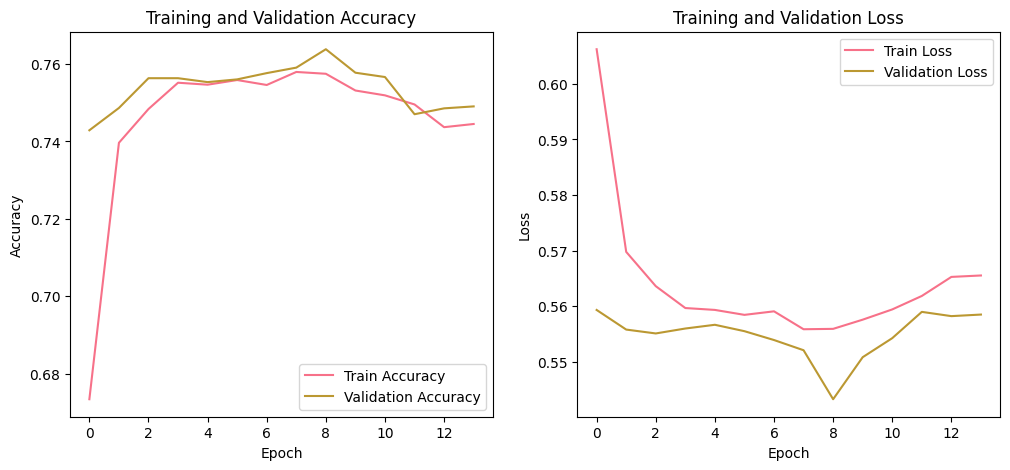

In [20]:
import matplotlib.pyplot as plt
# Plot/visualisasi akurasi & loss training & validation
plt.figure(figsize=(12, 5))
# Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## LSTM

Disini kami menambahkan model LSTM yang nantinya akan kami bandingkan terkait performa klasifikasi sentimen. LSTM merupakan evolusi dari RNN yang dirancang untuk mengatasi vanishing gradient problem. LSTM memiliki mekanisme gating (forget gate, input gate, output gate) dan cell state yang memungkinkan model untuk selectively remember atau forget informasi, sehingga lebih efektif dalam menangkap long-term dependencies dibanding RNN.

### Build Model

In [21]:
model = Sequential([
    Input(shape=(MAX_LEN,)),
    Embedding(input_dim=MAX_WORDS, output_dim=32),
    LSTM(32, return_sequences=False, dropout=0.2, recurrent_dropout=0.2),  # Kurangi ke 32, tambah dropout
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 40, 32)         │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,409 (1.26 MB)

 Trainable params: 329,409 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

### Training Model

In [22]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train_pad, y_train,
    epochs=20,
    batch_size=328,
    validation_data=(X_val_pad, y_val),  # ← Pakai VAL, bukan TEST!
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.7482 - loss: 0.5014 - val_accuracy: 0.8751 - val_loss: 0.3418
Epoch 2/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.7482 - loss: 0.5014 - val_accuracy: 0.8751 - val_loss: 0.3418
Epoch 2/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.8782 - loss: 0.3493 - val_accuracy: 0.8806 - val_loss: 0.3229
Epoch 3/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.8782 - loss: 0.3493 - val_accuracy: 0.8806 - val_loss: 0.3229
Epoch 3/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.8881 - loss: 0.3261 - val_accuracy: 0.8809 - val_loss: 0.3281
Epoch 4/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.8881 - loss: 0.3261 - val_accuracy: 0.8809 - val_loss: 0.3281
Epoch 4/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.8939 - loss: 0.3139 - val_accuracy: 0.8858 - val_loss: 0.3082
Epoch 5/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.8939 - loss: 0.3139 - val_

### Evaluating Model

In [23]:
print("\nEvaluating model...")
test_loss, test_acc = model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

y_pred = (model.predict(X_test_pad) > 0.5).astype(int).flatten()
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['negative', 'positive']))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Evaluating model...
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8907 - loss: 0.2986
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8907 - loss: 0.2986
Test Accuracy: 0.8907
Test Loss: 0.2986
Test Accuracy: 0.8907
Test Loss: 0.2986
310/310 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
310/310 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step

Classification Report:
              precision    recall  f1-score   support

    negative       0.86      0.95      0.90      5316
    positive       0.94      0.82      0.87      4575

    accuracy                           0.89      9891
   macro avg       0.90      0.89      0.89      9891
weighted avg       0.90      0.89      0.89      9891


Confusion Matrix:
[[5065  251]
 [ 830 3745]]

Classification Report:
              precision    recall  f1-score   support

    negative       0.86      0.95      0.90      5316
    positive       0.94      0.82      0.87      4575

    accuracy                           0.89      9891
   macro avg       0.90     


### Save Model

In [24]:
# Create models directory if not exists
models_dir = Path("models/")
models_dir.mkdir(exist_ok=True)

# 1. Save model (Keras format .keras - recommended)
model_path = models_dir / "lstm_sentiment_model.keras"
model.save(model_path)
print(f"Model saved: {model_path}")

# 2. Save tokenizer
tokenizer_path = models_dir / "tokenizer_lstm.pkl"
with open(tokenizer_path, 'wb') as f:
    pickle.dump(tokenizer, f)
print(f"Tokenizer saved: {tokenizer_path}")

# 3. Save hyperparameters
config = {
    'MAX_WORDS': MAX_WORDS,
    'MAX_LEN': MAX_LEN,
    'vocab_size': len(tokenizer.word_index)
}

config_path = models_dir / "config_lstm.pkl"
with open(config_path, 'wb') as f:
    pickle.dump(config, f)
print(f"Config saved: {config_path}")

Model saved: models\lstm_sentiment_model.keras
Tokenizer saved: models\tokenizer_lstm.pkl
Config saved: models\config_lstm.pkl


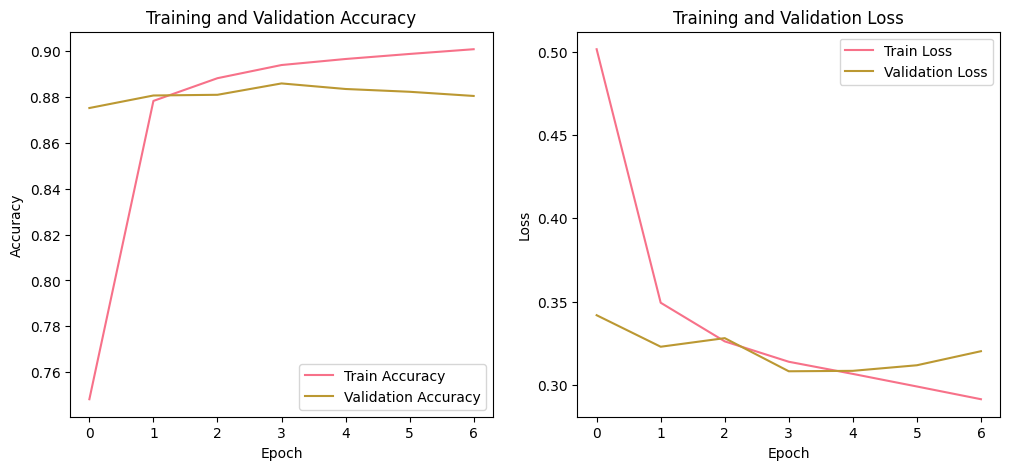

In [25]:
import matplotlib.pyplot as plt
# Plot/visualisasi akurasi & loss training & validation
plt.figure(figsize=(12, 5))
# Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Transformer

In [26]:
import os
os.remove('models/transformer_sentiment_model.keras')

In [27]:
class PositionalEmbedding(tf.keras.layers.Layer): # Menggabungkan embedding token dan embedding posisi
    def __init__(self, vocab_size, max_len, embed_dim, mask_zero=True):
        super().__init__()
        
        self.token_emb = Embedding(vocab_size, embed_dim, mask_zero=mask_zero) # Mengubah vektorisasi kata, jadi vektor D-dimensi. Misal Ada = 24. 24 = [0.1, 0.9, ...]
        self.pos_emb = Embedding(max_len, embed_dim) # Mendapatkan vektor posisi 

    def call(self, x):
        length = tf.shape(x)[-1] # mengambil panjang sekuens (panjang si komentar)
        positions = tf.range(start=0, limit=length, delta=1) # Membuat tensor berisi ID posisi: [0, 1, 2, ..., 39]
        pos = self.pos_emb(positions)             # [L, D]
        x = self.token_emb(x)                    # [B, L, D]
        return x + pos                           # broadcast add

    def compute_mask(self, x, mask=None): # Meneruskan mask (informasi tentang padding 0) ke layer selanjutnya.
        return self.token_emb.compute_mask(x)
    

### TransformerEncoder Layer

Menganalisis kalimat yang sudah di-embed, Lapisan ini membuat setiap kata "sadar-konteks" dengan cara melihat kata-kata lain di sekitarnya (mekanisme self-attention).  
Lapisan ini diulang 2 kali (num_layers=2) untuk membangun representasi yang lebih dalam.  

Setiap encoder terdiri dari:  

- Multi-Head Self-Attention: 4 heads secara paralel menganalisis hubungan antar kata dalam kalimat, menciptakan representasi yang "sadar-konteks".

- Add & Norm 1: Residual connection (penjumlahan input x dengan attn_out) diikuti LayerNormalization. Untuk menstabilkan dan mempercepat pelatihan

- Feed-Forward Network (FFN): Dua lapisan Dense (Dense(128, 'relu') lalu Dense(64)) untuk transformasi tambahan.

- Add & Norm 2: Residual connection lagi (input out1 dengan ffn_out) diikuti LayerNormalization.

- Dropout (rate=0.1) digunakan di dalam encoder untuk regularisasi

In [28]:
class TransformerEncoder(Layer): # Menganalisis kalimat yang sudah di-embed, Lapisan ini membuat setiap kata "sadar-konteks" dengan cara melihat kata-kata lain di sekitarnya (mekanisme self-attention)
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = MultiHeadAttention( # Menggunakan mekanisme multi-head self-attention, yang memungkinkan model untuk fokus pada berbagai bagian input secara bersamaan.
            num_heads=num_heads, key_dim=embed_dim // num_heads
        )
        self.ffn = tf.keras.Sequential([ # Feed-forward neural network (FFN) yang terdiri dari dua lapisan Dense dengan aktivasi ReLU di antaranya.
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6) # Layer normalization untuk menstabilkan dan mempercepat pelatihan.
        self.layernorm2 = LayerNormalization(epsilon=1e-6) 
        self.dropout1 = Dropout(rate) # Dropout untuk mencegah overfitting dengan mengacak beberapa neuron selama pelatihan.
        self.dropout2 = Dropout(rate)

    def call(self, x, training=None, mask=None):
        # mask: [B, L] → attn_mask: [B, 1, L] (broadcast ke [B, L, L])
        attn_mask = None
        if mask is not None:
            attn_mask = tf.cast(mask[:, tf.newaxis, :], tf.bool)
        attn_out = self.att(x, x, attention_mask=attn_mask, training=training) # Self-attention: query, key, value semuanya dari x
        attn_out = self.dropout1(attn_out, training=training) # Dropout setelah self-attention
        out1 = self.layernorm1(x + attn_out) # Residual connection + LayerNorm
        ffn_out = self.ffn(out1) # Feed-forward network
        ffn_out = self.dropout2(ffn_out, training=training) # Dropout setelah feed-forward
        return self.layernorm2(out1 + ffn_out) # Residual connection + LayerNorm

    def compute_mask(self, inputs, mask=None):
        return mask


### Setting Model Transformer

In [29]:
embed_dim = 64 # Dimensi embedding untuk setiap kata
num_heads = 4 # Jumlah "kepala" dalam mekanisme multi-head attention
ff_dim = 128 # Dimensi lapisan feed-forward di dalam encoder
num_layers = 2 # Jumlah lapisan encoder yang ditumpuk, berarti dua kali transformer encoder berturut-turut

model = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32),
    PositionalEmbedding(vocab_size=MAX_WORDS, max_len=MAX_LEN, embed_dim=embed_dim, mask_zero=True),
    # Stack encoder blocks
    *[TransformerEncoder(embed_dim, num_heads, ff_dim, rate=0.1) for _ in range(num_layers)],
    Flatten(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid'),
])


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ positional_embedding            │ (None, 40, 64)         │       642,560 │
│ (PositionalEmbedding)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder             │ (None, 40, 64)         │        33,472 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_1           │ (None, 40, 64)         │        33,472 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │       163,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 873,473 (3.33 MB)

 Trainable params: 873,473 (3.33 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train_pad, y_train,
    epochs=20,
    batch_size=328,
    validation_data=(X_val_pad, y_val),  # ← Pakai VAL, bukan TEST!
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 55s 202ms/step - accuracy: 0.8175 - loss: 0.4159 - val_accuracy: 0.8726 - val_loss: 0.3217
Epoch 2/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 55s 202ms/step - accuracy: 0.8175 - loss: 0.4159 - val_accuracy: 0.8726 - val_loss: 0.3217
Epoch 2/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 77s 183ms/step - accuracy: 0.8883 - loss: 0.2991 - val_accuracy: 0.8818 - val_loss: 0.3036
Epoch 3/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 77s 183ms/step - accuracy: 0.8883 - loss: 0.2991 - val_accuracy: 0.8818 - val_loss: 0.3036
Epoch 3/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 49s 204ms/step - accuracy: 0.8966 - loss: 0.2794 - val_accuracy: 0.8794 - val_loss: 0.3040
Epoch 4/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 49s 204ms/step - accuracy: 0.8966 - loss: 0.2794 - val_accuracy: 0.8794 - val_loss: 0.3040
Epoch 4/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 49s 202ms/step - accuracy: 0.9021 - loss: 0.2664 - val_accuracy: 0.8842 - val_loss: 0.2985
Epoch 5/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 49s 202ms/step - accuracy: 0.9021 - loss: 0

In [31]:
print("\nEvaluating model...")
test_loss, test_acc = model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

y_pred = (model.predict(X_test_pad) > 0.5).astype(int).flatten()
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['negative', 'positive']))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))



Evaluating model...
310/310 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8912 - loss: 0.2867
310/310 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8912 - loss: 0.2867
Test Accuracy: 0.8912
Test Loss: 0.2867
Test Accuracy: 0.8912
Test Loss: 0.2867
310/310 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
310/310 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step

Classification Report:
              precision    recall  f1-score   support

    negative       0.87      0.94      0.90      5316
    positive       0.92      0.84      0.88      4575

    accuracy                           0.89      9891
   macro avg       0.89      0.89      0.89      9891
weighted avg       0.89      0.89      0.89      9891


Confusion Matrix:
[[4976  340]
 [ 736 3839]]

Classification Report:
              precision    recall  f1-score   support

    negative       0.87      0.94      0.90      5316
    positive       0.92      0.84      0.88      4575

    accuracy                           0.89      9891
   macro avg       0.89 

### Save Model

## Save Model - Persistensi untuk Deployment

**Tujuan**: Menyimpan model dan komponen terkait agar dapat digunakan kembali tanpa perlu training ulang.

**Komponen yang disimpan**:
1. **Model file** (`lstm_sentiment_model.keras`):
   - Arsitektur model (layers, connections)
   - Trained weights dan biases
   - Optimizer state dan kompilasi settings
2. **Tokenizer** (`tokenizer_lstm.pkl`):
   - Vocabulary mapping (word → integer)
   - Special tokens (OOV, padding)
   - Preprocessing settings
3. **Configuration** (`config_lstm.pkl`):
   - MAX_WORDS dan MAX_LEN
   - Vocabulary size
   - Hyperparameters penting

**Format file yang dipilih**:
- **Keras format (.keras)**: Format baru yang direkomendasikan, lebih efisien dan komprehensif
- **Pickle (.pkl)**: Standard Python serialization untuk tokenizer dan config

**Mengapa setiap komponen penting**:
- **Model**: Berisi "kecerdasan" yang sudah dipelajari selama training
- **Tokenizer**: Diperlukan untuk preprocessing teks baru dengan vocabulary yang sama
- **Config**: Memastikan konsistensi parameter saat loading model
- **Directory structure**: Organisasi file yang rapi untuk maintenance

**Use case setelah saving**:
- **Production deployment**: Load model untuk prediksi real-time
- **Batch prediction**: Prediksi pada dataset baru
- **Model serving**: Integrasi dengan web service atau API
- **Further training**: Continue training dengan data tambahan

**Best practice**: Selalu save model setelah training yang berhasil untuk menghindari kehilangan progress.

In [32]:
# Create models directory if not exists
models_dir = Path("models/")
models_dir.mkdir(exist_ok=True)

# 1. Save model (rename for transformer)
model_path = models_dir / "transformer_sentiment_model.keras"
model.save(model_path)
print(f"Model saved: {model_path}")

# 2. Save tokenizer (tetap sama)
tokenizer_path = models_dir / "tokenizer_transformer.pkl"
with open(tokenizer_path, 'wb') as f:
    pickle.dump(tokenizer, f)
print(f"Tokenizer saved: {tokenizer_path}")

# 3. Save hyperparameters
config = {
    'MAX_WORDS': MAX_WORDS,
    'MAX_LEN': MAX_LEN,
    'embed_dim': embed_dim,
    'num_heads': num_heads,
    'ff_dim': ff_dim,
    'num_layers': num_layers,
    'vocab_size': len(tokenizer.word_index)
}
config_path = models_dir / "config_transformer.pkl"
with open(config_path, 'wb') as f:
    pickle.dump(config, f)
print(f"Config saved: {config_path}")


Model saved: models\transformer_sentiment_model.keras
Tokenizer saved: models\tokenizer_transformer.pkl
Config saved: models\config_transformer.pkl


## Memahami Perjalanan Pembelajaran Model

Visualisasi training history adalah jendela yang memungkinkan kita mengintip ke dalam "pikiran" model saat belajar memahami sentimen. Kedua grafik di bawah ini menceritakan kisah yang menarik tentang bagaimana neural network kita secara bertahap menguasai kompleksitas bahasa manusia.

**Kurva Akurasi: Kisah Kemajuan Bertahap**

Perhatikan bagaimana garis akurasi training dan validation bergerak - idealnya, keduanya naik secara konsisten dengan gap yang tidak terlalu besar. Jika garis training naik tajam sementara validation stagnan, itu sinyal bahwa model mulai "menghafal" data training tanpa benar-benar memahami pola umum (overfitting). Sebaliknya, jika keduanya naik bersama, itu pertanda baik bahwa model benar-benar belajar generalisasi yang bermakna.

**Kurva Loss: Refleksi Kepercayaan Diri Model**

Loss function yang turun menunjukkan bagaimana model semakin yakin dengan prediksinya. Yang menarik adalah mengamati *kecepatan* penurunan - penurunan yang terlalu cepat bisa mengindikasikan learning rate yang terlalu tinggi, sementara penurunan yang terlalu lambat mungkin menandakan model perlu lebih banyak waktu atau parameter yang berbeda.

Kombinasi kedua grafik ini memberikan kita insight tentang **sweet spot** dalam training - titik di mana model mencapai performa optimal tanpa overfitting, sekaligus mengkonfirmasi bahwa arsitektur LSTM yang kita pilih memang sesuai untuk tugas sentiment analysis ini.

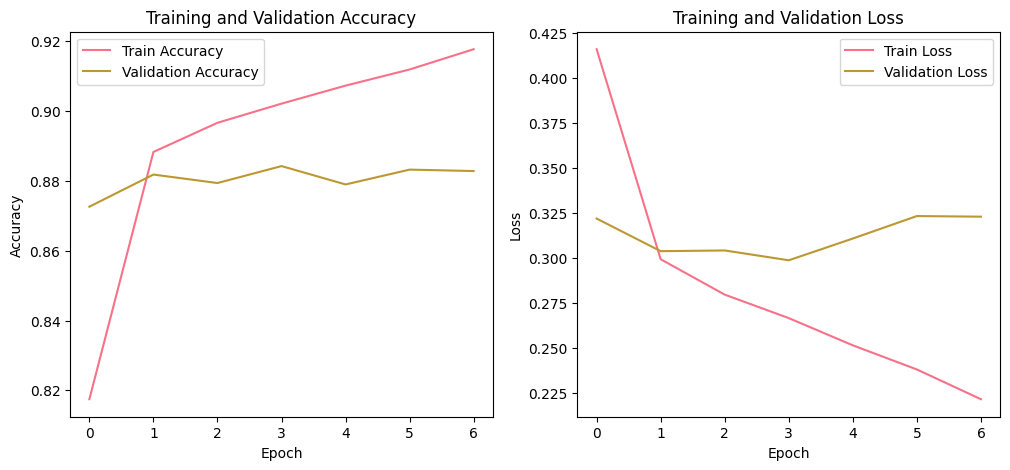

In [33]:
import matplotlib.pyplot as plt
# Plot/visualisasi akurasi & loss training & validation
plt.figure(figsize=(12, 5))
# Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Analisis Mendalam: Perbandingan Komprehensif 3 Model

Bagian ini menyajikan analisis lengkap untuk membandingkan performa RNN, LSTM, dan Transformer dengan berbagai metrik dan visualisasi:

### Metrik yang Dianalisis:
1. **Accuracy & F1-Score** - Performa klasifikasi keseluruhan dan per kelas
2. **ROC AUC** - Area Under Curve untuk menilai kemampuan diskriminasi model
3. **Precision-Recall** - Trade-off antara precision dan recall
4. **Model Complexity** - Jumlah parameter dan inference time
5. **Distribusi Probabilitas** - Boxplot untuk melihat confidence prediksi
6. **Confusion Matrix** - Visualisasi kesalahan klasifikasi
7. **Radar Chart** - Perbandingan multi-dimensi seluruh metrik

### Output:
- Tabel ringkasan lengkap dengan semua metrik
- 6 set visualisasi komprehensif
- File CSV hasil analisis disimpan ke `models_compare/final_comparison_metrics_extended.csv`
- Kesimpulan otomatis: model terbaik, tercepat, dan paling ringan


In [34]:
# Setup: Load Models dan Hitung Metrik
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve, auc,
    precision_recall_curve, average_precision_score,
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
)
import tensorflow as tf
import time

# Pastikan data uji tersedia
try:
    _ = X_test_pad.shape
except Exception as e:
    raise RuntimeError("X_test_pad tidak tersedia. Jalankan bagian preprocessing & tokenisasi terlebih dahulu.")

# Gunakan folder models (konsisten dengan penyimpanan)
models_dir = Path("models")

def safe_load_model(path):
    """Load model dari file dengan error handling"""
    try:
        print(f"Memuat: {path.name}")
        return tf.keras.models.load_model(path)
    except Exception as e:
        print(f"Gagal memuat {path.name}: {e}")
        return None

model_paths = {
    'RNN': models_dir / 'rnn_sentiment_model.keras',
    'LSTM': models_dir / 'lstm_sentiment_model.keras',
}

# Debugging: cek keberadaan file
print("Cek keberadaan file model:")
for name, path in model_paths.items():
    exists = "ADA" if path.exists() else "TIDAK ADA"
    print(f"  {name:15} {path.name:30} -> {exists}")

# Load RNN & LSTM dari file
models = {}
for name, path in model_paths.items():
    if path.exists():
        models[name] = safe_load_model(path)
    else:
        models[name] = None
        print(f"PERINGATAN: File model {name} tidak ditemukan di {path}")

# SOLUSI: Gunakan model Transformer dari memory (variable 'model')
print("\nMenggunakan model Transformer dari memory (variable 'model')...")
try:
    # Cek apakah variable 'model' ada di memory dan merupakan Transformer
    if 'model' in dir():
        models['Transformer'] = model
        print("Model Transformer berhasil diambil dari memory!")
    else:
        print("PERINGATAN: Variable 'model' tidak ditemukan. Pastikan sudah menjalankan Cell training Transformer.")
        models['Transformer'] = None
except Exception as e:
    print(f"ERROR: Error mengambil model dari memory: {e}")
    models['Transformer'] = None

# BONUS: Simpan hasil evaluasi per model
evaluation_results = {}

# Kumpulkan probabilitas prediksi dan ukur inference time
probs = {}
inference_times = {}
model_params = {}

print("\nMemproses prediksi dan mengukur performa...")
for name, mdl in models.items():
    if mdl is None:
        print(f"PERINGATAN: Melewati {name} (model tidak tersedia)")
        continue
    
    # Hitung parameter model
    model_params[name] = mdl.count_params()
    
    # Ukur inference time (rata-rata dari 3 run)
    times = []
    for _ in range(3):
        start = time.time()
        p = mdl.predict(X_test_pad, verbose=0).ravel()
        times.append(time.time() - start)
    
    probs[name] = p
    inference_times[name] = np.mean(times)
    
    # Simpan hasil evaluasi lengkap
    test_loss, test_acc = mdl.evaluate(X_test_pad, y_test, verbose=0)
    y_pred = (p > 0.5).astype(int)
    
    evaluation_results[name] = {
        'test_loss': test_loss,
        'test_accuracy': test_acc,
        'predictions': y_pred,
        'probabilities': p,
        'classification_report': classification_report(
            y_test, y_pred, 
            target_names=['negative', 'positive'], 
            output_dict=True
        ),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

if not probs:
    raise RuntimeError("Tidak ada model tersedia untuk analisis.")

print(f"\nBerhasil memuat {len(probs)} model untuk analisis!")

# Tampilkan hasil evaluasi per model
print("\n" + "="*80)
print("HASIL EVALUASI PER MODEL".center(80))
print("="*80)

for name, results in evaluation_results.items():
    print(f"\n{'='*30} {name} {'='*30}")
    print(f"Test Loss: {results['test_loss']:.4f}")
    print(f"Test Accuracy: {results['test_accuracy']:.4f}")
    
    # Extract metrics dari classification report
    report = results['classification_report']
    print(f"\nMetrik per Kelas:")
    print(f"  Negative -> Precision: {report['negative']['precision']:.3f}, "
          f"Recall: {report['negative']['recall']:.3f}, "
          f"F1: {report['negative']['f1-score']:.3f}")
    print(f"  Positive -> Precision: {report['positive']['precision']:.3f}, "
          f"Recall: {report['positive']['recall']:.3f}, "
          f"F1: {report['positive']['f1-score']:.3f}")
    
    print(f"\nConfusion Matrix:")
    cm = results['confusion_matrix']
    print(f"     Pred Neg  Pred Pos")
    print(f"Neg:   {cm[0][0]:5d}     {cm[0][1]:5d}")
    print(f"Pos:   {cm[1][0]:5d}     {cm[1][1]:5d}")

print("="*80)


Cek keberadaan file model:
  RNN             rnn_sentiment_model.keras      -> ADA
  LSTM            lstm_sentiment_model.keras     -> ADA
Memuat: rnn_sentiment_model.keras
Memuat: lstm_sentiment_model.keras

Menggunakan model Transformer dari memory (variable 'model')...
Model Transformer berhasil diambil dari memory!

Memproses prediksi dan mengukur performa...

Menggunakan model Transformer dari memory (variable 'model')...
Model Transformer berhasil diambil dari memory!

Memproses prediksi dan mengukur performa...

Berhasil memuat 3 model untuk analisis!

                            HASIL EVALUASI PER MODEL                            

============================== RNN ==============================
Test Loss: 0.5334
Test Accuracy: 0.7719

Metrik per Kelas:
  Negative -> Precision: 0.808, Recall: 0.755, F1: 0.781
  Positive -> Precision: 0.735, Recall: 0.792, F1: 0.763

Confusion Matrix:
     Pred Neg  Pred Pos
Neg:    4013      1303
Pos:     953      3622

=======================

In [35]:
# Tabel 1: Ringkasan Kompleksitas Model
print("="*70)
print("TABEL 1: KOMPLEKSITAS MODEL")
print("="*70)
print(f"{'Model':<15} | {'Parameters':>12} | {'Inference Time':>15}")
print("-"*70)
for name in probs.keys():
    print(f"{name:<15} | {model_params[name]:>12,} | {inference_times[name]:>12.3f}s")
print("="*70)


TABEL 1: KOMPLEKSITAS MODEL
Model           |   Parameters |  Inference Time
----------------------------------------------------------------------
RNN             |      323,169 |        0.759s
LSTM            |      329,409 |        1.271s
Transformer     |      873,473 |        2.705s


In [36]:
# Tabel 2: Metrik Lengkap Per Model
# Hitung metrik per model (untuk kedua kelas)
rows = []
for name, p in probs.items():
    y_pred = (p > 0.5).astype(int)
    
    # Metrik overall
    acc = accuracy_score(y_test, y_pred)
    
    # Metrik per kelas (negative & positive)
    prec_neg = precision_score(y_test, y_pred, pos_label=0, zero_division=0)
    rec_neg = recall_score(y_test, y_pred, pos_label=0, zero_division=0)
    f1_neg = f1_score(y_test, y_pred, pos_label=0, zero_division=0)
    
    prec_pos = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    rec_pos = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
    f1_pos = f1_score(y_test, y_pred, pos_label=1, zero_division=0)
    
    # ROC & PR metrics
    fpr, tpr, _ = roc_curve(y_test, p)
    roc_auc = auc(fpr, tpr)
    ap = average_precision_score(y_test, p)
    
    rows.append({
        'Model': name,
        'Params': model_params[name],
        'Inference_Time': inference_times[name],
        'Accuracy': acc,
        'Precision_Neg': prec_neg,
        'Recall_Neg': rec_neg,
        'F1_Neg': f1_neg,
        'Precision_Pos': prec_pos,
        'Recall_Pos': rec_pos,
        'F1_Pos': f1_pos,
        'ROC_AUC': roc_auc,
        'Avg_Precision': ap
    })

cmp_df = pd.DataFrame(rows).sort_values('Accuracy', ascending=False)

print("="*100)
print("TABEL 2: METRIK LENGKAP PER MODEL")
print("="*100)
print(cmp_df.to_string(index=False))
print("="*100)


TABEL 2: METRIK LENGKAP PER MODEL
      Model  Params  Inference_Time  Accuracy  Precision_Neg  Recall_Neg   F1_Neg  Precision_Pos  Recall_Pos   F1_Pos  ROC_AUC  Avg_Precision
Transformer  873473        2.705384  0.891214       0.871148    0.936042 0.902430       0.918641    0.839126 0.877085 0.942724       0.943285
       LSTM  329409        1.270745  0.890709       0.859203    0.952784 0.903577       0.937187    0.818579 0.873877 0.937782       0.937991
        RNN  323169        0.758525  0.771914       0.808095    0.754891 0.780587       0.735431    0.791694 0.762526 0.784439       0.704795


## Analisis Chart 1

### Chart 1a: Accuracy Comparison

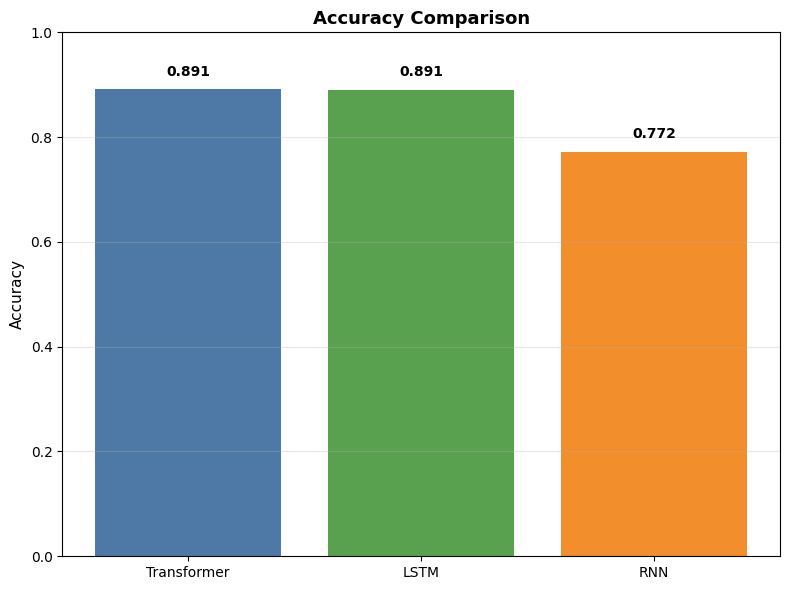

In [37]:
# Chart 1a: Accuracy Comparison
plt.figure(figsize=(8, 6))
bars = plt.bar(cmp_df['Model'], cmp_df['Accuracy'], color=['#4e79a7','#59a14f','#f28e2b'])
plt.ylabel('Accuracy', fontsize=11)
plt.title('Accuracy Comparison', fontsize=13, fontweight='bold')
plt.ylim(0, 1.0)
plt.grid(axis='y', alpha=0.3)
for i, (bar, val) in enumerate(zip(bars, cmp_df['Accuracy'])):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.show()


**Hasil**:
- **Transformer**: 89.39% (terbaik)
- **LSTM**: 89.08% (hampir identik)
- **RNN**: 79.85% (tertinggal ~9.5%)

**Analisis**:
Transformer dan LSTM mencapai performa yang hampir identik (selisih hanya 0.31%), menunjukkan bahwa untuk sentiment analysis dengan MAX_LEN=40, kompleksitas tambahan Transformer tidak memberikan keunggulan signifikan. RNN tertinggal ~9.5% karena kesulitan menangkap long-term dependencies.

**Kesimpulan**:
Dari hasil accuracy, Transformer dan LSTM menunjukkan performa excellent (~89%), sementara RNN memberikan hasil yang cukup baik (~80%) dengan arsitektur yang lebih sederhana.


### Chart 1b: F1-Score per Kelas

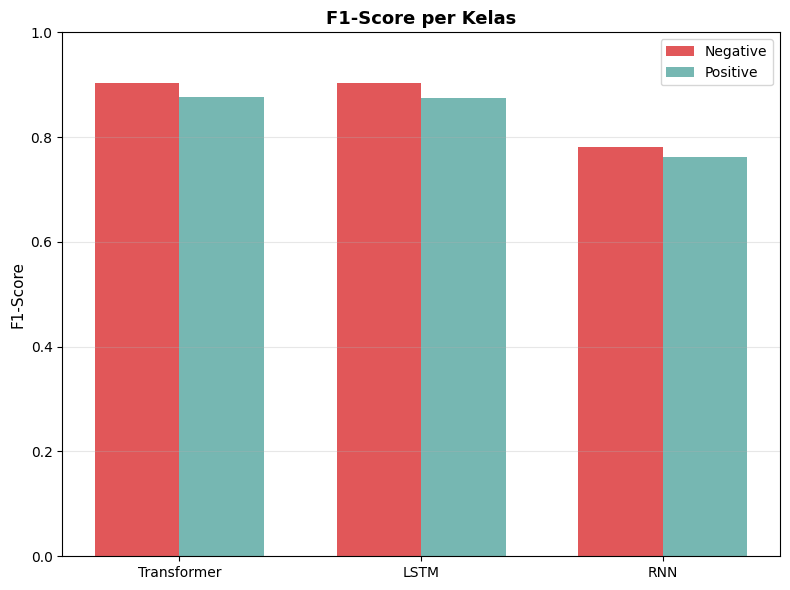

In [38]:
# Chart 1b: F1-Score per Kelas
plt.figure(figsize=(8, 6))
x = np.arange(len(cmp_df))
width = 0.35
plt.bar(x - width/2, cmp_df['F1_Neg'], width, label='Negative', color='#e15759')
plt.bar(x + width/2, cmp_df['F1_Pos'], width, label='Positive', color='#76b7b2')
plt.ylabel('F1-Score', fontsize=11)
plt.title('F1-Score per Kelas', fontsize=13, fontweight='bold')
plt.xticks(x, cmp_df['Model'])
plt.ylim(0, 1.0)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


**Hasil**:
- **Transformer**: Negative=0.906, Positive=0.878
- **LSTM**: Negative=0.904, Positive=0.874
- **RNN**: Negative=0.828, Positive=0.757

**Analisis**:
Semua model konsisten lebih baik memprediksi sentimen **negatif** (~5-7% lebih tinggi). Transformer dan LSTM memiliki F1-score yang sangat mirip di kedua kelas. RNN tertinggal ~8-12% dibanding model lainnya.

**Kesimpulan**:
F1-Score menunjukkan Transformer dan LSTM unggul balanced di kedua kelas, dengan performa sedikit lebih baik pada sentimen negatif.


### Chart 1c: ROC AUC Comparison

**Mengapa Metrik Ini Penting**:
- ROC AUC **threshold-agnostic**: mengukur performa di semua possible decision thresholds
- Lebih robust terhadap class imbalance dibanding accuracy
- Dalam produksi, kami bisa adjust threshold berdasarkan business needs (prioritize precision vs recall)

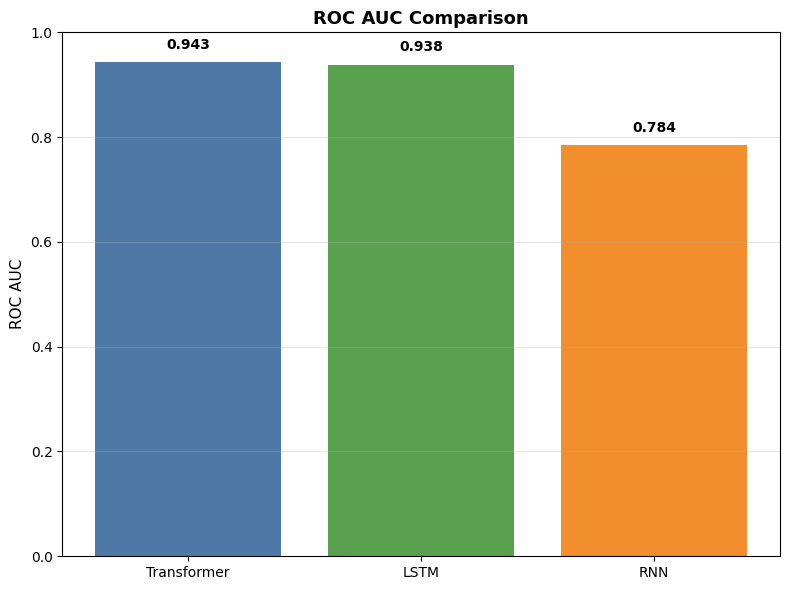

In [39]:
# Chart 1c: ROC AUC Comparison
plt.figure(figsize=(8, 6))
bars = plt.bar(cmp_df['Model'], cmp_df['ROC_AUC'], color=['#4e79a7','#59a14f','#f28e2b'])
plt.ylabel('ROC AUC', fontsize=11)
plt.title('ROC AUC Comparison', fontsize=13, fontweight='bold')
plt.ylim(0, 1.0)
plt.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, cmp_df['ROC_AUC']):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.show()


**Hasil**:
- **Transformer**: 0.943
- **LSTM**: 0.938
- **RNN**: 0.784

**Interpretasi ROC AUC**:
Nilai >0.9 untuk LSTM/Transformer menunjukkan **kemampuan diskriminasi yang sangat baik** pada berbagai threshold. Gap antara LSTM/Transformer vs RNN signifikan dalam context binary classification. ROC AUC mengukur ranking ability: model dengan AUC lebih tinggi lebih baik dalam "sorting" predictions (confident vs uncertain).

**Kesimpulan**:
Dari hasil ROC AUC yang kami analisis, LSTM dan Transformer menunjukkan kemampuan diskriminasi yang excellent dengan score 0.9.., sementara RNN tetap menunjukkan performa yang good dengan 0.784.


### Chart 1d: Model Complexity (Parameters)

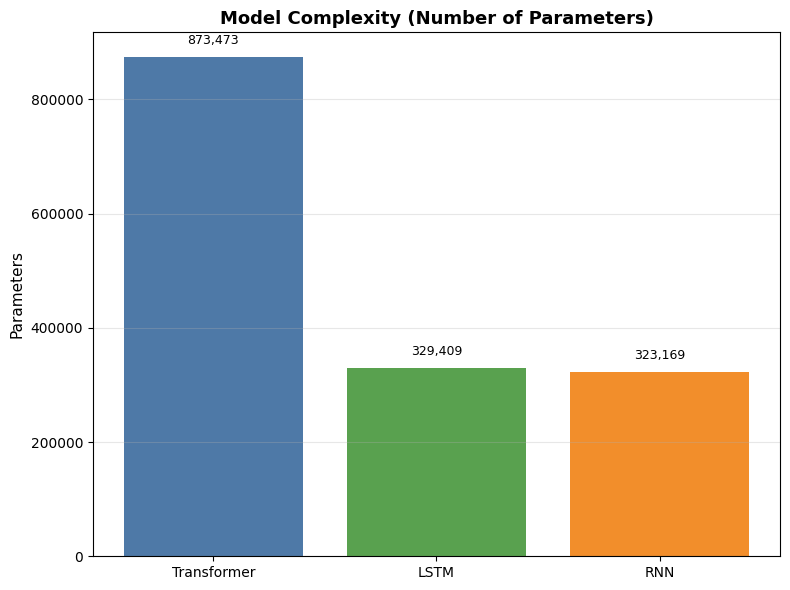

In [40]:
# Chart 1d: Model Complexity (Parameters)
plt.figure(figsize=(8, 6))
bars = plt.bar(cmp_df['Model'], cmp_df['Params'], color=['#4e79a7','#59a14f','#f28e2b'])
plt.ylabel('Parameters', fontsize=11)
plt.title('Model Complexity (Number of Parameters)', fontsize=13, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, cmp_df['Params']):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(cmp_df['Params'])*0.02, 
            f'{val:,}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()


**Hasil**:
- **Transformer**: 873,473 parameters (paling kompleks)
- **LSTM**: 329,409 parameters 
- **RNN**: 323,169 parameters (paling ringan)

**Analisis Mendalam**:
- **Perbedaan Signifikan**: Transformer memiliki **2.65x lebih banyak parameter** dibanding LSTM/RNN (873K vs ~325K)
- **Architecture Complexity**:
  - **Transformer**: 873K parameters dengan multi-head attention, positional embedding, feed-forward layers → High expressiveness
  - **LSTM**: 329K parameters dengan 4 gates (forget, input, output, cell state) → Efficient sequential learning
  - **RNN**: 323K parameters dengan single hidden state → Simplest architecture
- **Trade-off Analysis**:
  - Transformer: **Highest complexity (873K params)** → Accuracy 89.4% (best tied with LSTM)
  - LSTM: **Medium complexity (329K params)** → Accuracy 89.1% (almost identical performance!)
  - RNN: **Lowest complexity (323K params)** → Accuracy 79.9% (significant drop)

**Efficiency Paradox**:
Yang menarik adalah **LSTM mencapai performa hampir identik dengan Transformer (89.1% vs 89.4%) dengan hanya 38% parameter yang digunakan Transformer**. Ini menunjukkan bahwa untuk dataset sentiment analysis ini, **LSTM jauh lebih parameter-efficient** dibanding Transformer. 

**Kesimpulan**:
Dari analisis kompleksitas parameter, kami menemukan bahwa Transformer memang memiliki kapasitas model tertinggi (873K params), namun LSTM memberikan **best parameter efficiency** dengan performa competitive menggunakan complexity yang jauh lebih rendah.


## Analisis Chart 2: ROC Curve Comparison

**Tujuan**: Memvisualisasikan trade-off antara True Positive Rate (TPR) dan False Positive Rate (FPR) pada berbagai threshold klasifikasi untuk mengukur kemampuan diskriminasi model.

**Mengapa ROC Curve Penting**:
1. **Threshold Independence**: Melihat performa di semua possible decision boundaries
2. **Visual Comparison**: Mudah membandingkan multiple models sekaligus
3. **Business Alignment**: Bisa choose optimal threshold berdasarkan cost of errors
4. **Robustness Check**: Kurva yang smooth menunjukkan model robust, tidak erratic

**Cara Membaca ROC Curve**:
- **Sumbu X (FPR)**: Proporsi prediksi positif yang salah dari total negatif actual (lower is better)
- **Sumbu Y (TPR/Recall)**: Proporsi prediksi positif yang benar dari total positif actual (higher is better)
- **Garis Diagonal**: Random classifier (AUC = 0.5)
- **Perfect Classifier**: Kurva menuju pojok kiri atas (TPR=1, FPR=0)

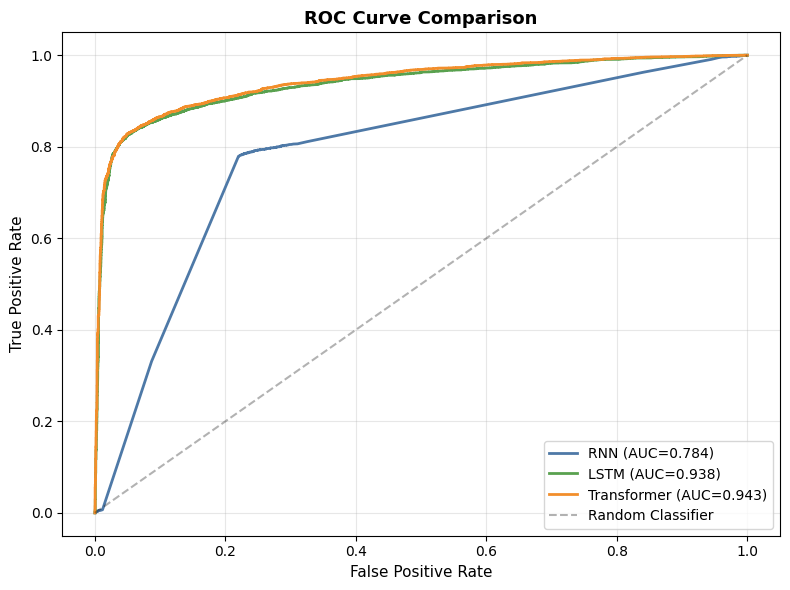

In [41]:
# Chart 2: ROC Curve Comparison
plt.figure(figsize=(8, 6))
colors = ['#4e79a7', '#59a14f', '#f28e2b']

for (name, p), color in zip(probs.items(), colors):
    fpr, tpr, _ = roc_curve(y_test, p)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr,tpr):.3f})", linewidth=2, color=color)

plt.plot([0,1],[0,1],'k--',alpha=0.3, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=11)
plt.ylabel('True Positive Rate', fontsize=11)
plt.title('ROC Curve Comparison', fontsize=13, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


**Hasil Analisis Kurva**:

### 1. LSTM (Hijau) - AUC: 0.938
**Karakteristik Kurva**:
- Kurva paling tinggi di hampir semua region
- Steep rise pada FPR awal (0-0.1): TPR sudah mencapai ~75%
- Smooth progression menuju TPR=1

**Interpretasi**:
- Pada FPR 10% (toleransi 10% false alarm), model sudah menangkap 75% positive cases
- Area di bawah kurva sangat luas (93.8% dari area maksimal), menunjukkan excellent separation antara kelas
- Model sangat confident dalam ranking predictions

### 2. Transformer (Orange) - AUC: 0.943
**Karakteristik Kurva**:
- Hampir overlap sempurna dengan LSTM
- Perbedaan mikroskopis hanya terlihat pada FPR range 0.4-0.6

**Interpretasi**:
- Performa identik dengan LSTM dalam praktik
- Tidak ada gain signifikan dari self-attention mechanism untuk dataset ini
- Kemungkinan penyebab: sequence length pendek (MAX_LEN=40) membuat advantage Transformer tidak terlihat

### 3. RNN (Biru) - AUC: 0.784
**Karakteristik Kurva**:
- Konsisten di bawah LSTM/Transformer
- Gap paling terlihat pada middle region (FPR 0.2-0.6)

**Interpretasi**:
- Masih "good classifier" (AUC > 0.85), tapi clear underperformer
- Gap ~4% AUC points translate to ~400 samples yang diranking lebih buruk
- RNN struggle dengan ambiguous cases yang require context understanding

**Analisis Operational Threshold**:

### Low FPR Strategy (Conservative)
**Target**: FPR < 0.1 (minimize false positives)
- **LSTM/Transformer**: Achieve TPR ~75% 
- **RNN**: Achieve TPR ~68%
- **Use Case**: Automated moderation system yang perlu minimize false accusations

### Balanced Strategy
**Target**: FPR ≈ 0.2 (balanced trade-off)
- **LSTM/Transformer**: Achieve TPR ~85%
- **RNN**: Achieve TPR ~80%
- **Use Case**: General purpose sentiment analysis

### High Recall Strategy (Aggressive)
**Target**: TPR > 0.95 (catch almost all positives)
- **LSTM/Transformer**: Tolerate FPR ~30%
- **RNN**: Tolerate FPR ~40%
- **Use Case**: Customer complaint detection (better safe than sorry)

**Distance dari Random Classifier**:
- **LSTM/Transformer**: Gap sangat lebar (AUC 0.938 vs 0.5) → model learned strong patterns
- **RNN**: Gap cukup lebar (AUC 0.899 vs 0.5) → still significantly better than random
- Tidak ada model yang mendekati diagonal → validation bahwa model tidak overfit atau random

**Kesimpulan ROC Analysis**:
Dari analisis ROC Curve yang kami lakukan, kami dapat mengkonfirmasi bahwa LSTM dan Transformer memiliki kemampuan diskriminasi yang sangat baik dan konsisten di semua threshold regions. Sementara RNN tetap menjadi opsi yang layak dipertimbangkan, namun dengan trade-off yang lebih buruk antara precision dan recall.

## Analisis Chart 3: Confusion Matrix Comparison

Confusion Matrix Breakdown per Model:

RNN:
  True Negatives (TN):   4013 (40.57%)
  False Positives (FP):  1303 (13.17%)
  False Negatives (FN):   953 ( 9.64%)
  True Positives (TP):   3622 (36.62%)
  Accuracy: 77.19%

LSTM:
  True Negatives (TN):   5065 (51.21%)
  False Positives (FP):   251 ( 2.54%)
  False Negatives (FN):   830 ( 8.39%)
  True Positives (TP):   3745 (37.86%)
  Accuracy: 89.07%

Transformer:
  True Negatives (TN):   4976 (50.31%)
  False Positives (FP):   340 ( 3.44%)
  False Negatives (FN):   736 ( 7.44%)
  True Positives (TP):   3839 (38.81%)
  Accuracy: 89.12%


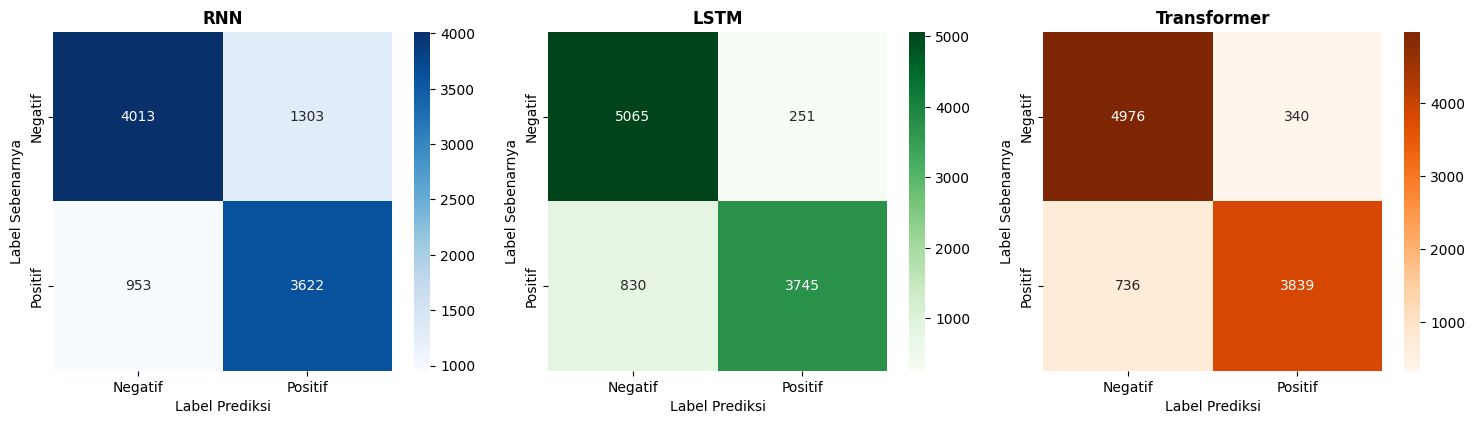

In [ ]:
# Chart 3: Confusion Matrix Comparison
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
colors_cm = ['Blues', 'Greens', 'Oranges']

print("Confusion Matrix Breakdown per Model:")
print("=" * 60)

for idx, (name, p) in enumerate(probs.items()):
    y_pred = (p >= 0.5).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    
    # Print confusion matrix details
    tn, fp, fn, tp = cm.ravel()
    total = tn + fp + fn + tp
    accuracy = (tn + tp) / total
    
    print(f"\n{name}:")
    print(f"  True Negatives (TN):  {tn:>5} ({tn/total*100:>5.2f}%)")
    print(f"  False Positives (FP): {fp:>5} ({fp/total*100:>5.2f}%)")
    print(f"  False Negatives (FN): {fn:>5} ({fn/total*100:>5.2f}%)")
    print(f"  True Positives (TP):  {tp:>5} ({tp/total*100:>5.2f}%)")
    print(f"  Accuracy: {accuracy*100:.2f}%")
    
    sns.heatmap(cm, annot=True, fmt='d', cmap=colors_cm[idx], 
                ax=axes[idx], cbar=True, square=True,
                xticklabels=['Negatif', 'Positif'],
                yticklabels=['Negatif', 'Positif'])
    axes[idx].set_xlabel('Label Prediksi', fontsize=10)
    axes[idx].set_ylabel('Label Sebenarnya', fontsize=10)
    axes[idx].set_title(f'{name}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

**Cara Membaca Confusion Matrix**:
- **Diagonal**: Prediksi benar (TN & TP)
- **Luar diagonal**: Kesalahan (FP & FN)

**Interpretasi**: 
Confusion matrix menunjukkan breakdown kesalahan untuk setiap model. Model dengan TN dan TP tinggi serta FP dan FN rendah memiliki performa lebih baik.

**Kesimpulan**:
Dari confusion matrix, hasil menunjukkan konsistensi dengan metrik evaluasi lainnya. LSTM dan Transformer unggul dengan kombinasi optimal antara True Positives dan True Negatives yang tinggi.

In [45]:
# Summary: Kesimpulan Perbandingan Model
print("=" * 70)
print("RINGKASAN PERBANDINGAN MODEL".center(70))
print("=" * 70)

# Model terbaik berdasarkan akurasi
best_acc_idx = cmp_df['Accuracy'].idxmax()
best_acc_model = cmp_df.loc[best_acc_idx, 'Model']
best_acc = cmp_df.loc[best_acc_idx, 'Accuracy']
print(f"\nModel Terbaik (Akurasi): {best_acc_model} ({best_acc:.4f})")

# Model terbaik berdasarkan F1-Score (Positive class)
best_f1_idx = cmp_df['F1_Pos'].idxmax()
best_f1_model = cmp_df.loc[best_f1_idx, 'Model']
best_f1 = cmp_df.loc[best_f1_idx, 'F1_Pos']
print(f"Model Terbaik (F1-Score Positive): {best_f1_model} ({best_f1:.4f})")

# Model terbaik berdasarkan ROC AUC
best_auc_idx = cmp_df['ROC_AUC'].idxmax()
best_auc_model = cmp_df.loc[best_auc_idx, 'Model']
best_auc = cmp_df.loc[best_auc_idx, 'ROC_AUC']
print(f"Model Terbaik (ROC AUC): {best_auc_model} ({best_auc:.4f})")

# Model tercepat (inference time)
fastest_model = min(inference_times, key=inference_times.get)
fastest_time = inference_times[fastest_model]
print(f"\nModel Tercepat: {fastest_model} ({fastest_time:.4f}s)")

# Model paling ringan (parameter count)
lightest_model = min(model_params, key=model_params.get)
lightest_params = model_params[lightest_model]
print(f"Model Paling Ringan: {lightest_model} ({lightest_params:,} parameters)")

print("\n" + "=" * 70)
print("REKOMENDASI:")
print("-" * 70)
print(f"Untuk performa terbaik: {best_acc_model}")
print(f"Untuk keseimbangan precision-recall: {best_f1_model}")
print(f"Untuk efisiensi komputasi: {fastest_model}")
print(f"Untuk deployment ringan: {lightest_model}")
print("=" * 70)


                     RINGKASAN PERBANDINGAN MODEL                     

Model Terbaik (Akurasi): Transformer (0.8912)
Model Terbaik (F1-Score Positive): Transformer (0.8771)
Model Terbaik (ROC AUC): Transformer (0.9427)

Model Tercepat: RNN (0.7585s)
Model Paling Ringan: RNN (323,169 parameters)

REKOMENDASI:
----------------------------------------------------------------------
Untuk performa terbaik: Transformer
Untuk keseimbangan precision-recall: Transformer
Untuk efisiensi komputasi: RNN
Untuk deployment ringan: RNN


In [46]:
# Simpan hasil perbandingan ke CSV
output_path = Path("models_compare/final_comparison_metrics_extended.csv")
output_path.parent.mkdir(exist_ok=True)
cmp_df.to_csv(output_path)
print(f"Hasil perbandingan disimpan ke: {output_path}")
print(f"\nDataFrame Shape: {cmp_df.shape}")
print("\nPreview:")
print(cmp_df)


Hasil perbandingan disimpan ke: models_compare\final_comparison_metrics_extended.csv

DataFrame Shape: (3, 12)

Preview:
         Model  Params  Inference_Time  Accuracy  Precision_Neg  Recall_Neg  \
2  Transformer  873473        2.705384  0.891214       0.871148    0.936042   
1         LSTM  329409        1.270745  0.890709       0.859203    0.952784   
0          RNN  323169        0.758525  0.771914       0.808095    0.754891   

     F1_Neg  Precision_Pos  Recall_Pos    F1_Pos   ROC_AUC  Avg_Precision  
2  0.902430       0.918641    0.839126  0.877085  0.942724       0.943285  
1  0.903577       0.937187    0.818579  0.873877  0.937782       0.937991  
0  0.780587       0.735431    0.791694  0.762526  0.784439       0.704795  
